<a href="https://colab.research.google.com/github/Dinarque/INALCO_Inalco_M2_ingenierie_connaissances_2025_eleves/blob/main/TP/TP1_The_fellowship_of_the_ontology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TP1 : La confrérie de l'ontologie

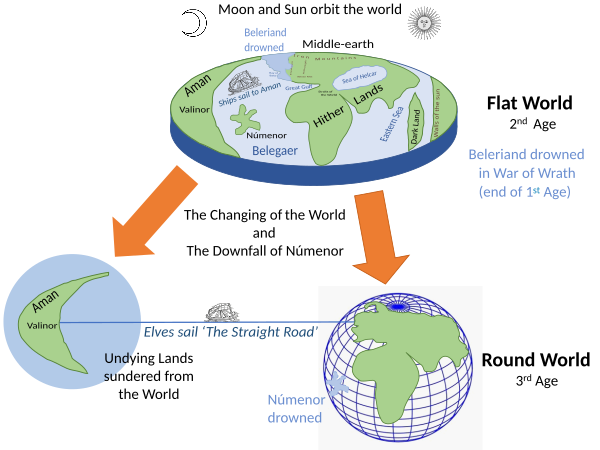

source:https://upload.wikimedia.org/wikipedia/commons/thumb/b/be/Downfall_of_N%C3%BAmenor.svg/600px-Downfall_of_N%C3%BAmenor.svg.png
(wikipedia)



L'objectif de ce TP est d'explorer les différentes méthodes d'automatisation de la constitution d'ontologies pour un domaine spécialisé.
La conception manuelle d'ontologies même avec des outils adaptés comme Protégé est fastidieuse, et en tant qu'experts en NLP, vous disposez d'une palette d'outils pour accélérer les choses !

On proposera un parcours à peu près chronologique (en terme technique) explorant différentes méthodes pour automatiser des étapes de la constitution d'une ontologie sur l'univers du Seigneur des Anneaux (Tolkien), depuis les approches purement statistiques à l'utilisation de LLMs (si on en trouve un !).

Un corpus d'environ 5000 articles issus de l'encyclopédie en ligne du seigneur des anneaux https://lotr.fandom.com/wiki/Main_Page a été sélectionné (pages informatives, normalement riches en concepts) pour plusieurs raisons:
* C'est un domaine pour lequel il n'existe pas (à ma connaissance) d'ontologie satisfaisante UPDATE : article du 14 Décembre. Il n'a pas fait d'onologie... https://medium.com/@victoralfons/the-agency-of-things-interpreting-the-lord-of-the-rings-through-object-oriented-ontology-fa538a1f2d67
* C'est un domaine peu structuré : cela vous forcera à déterminer quelles sont les méta relations essentielles pour structurer le domaine
* Ce domaine contient un vocabulaire très spécifique que ne "connaissent" pas les modèles comme BERT et forcera à se poser des questions sur l'adaptation de domaine.


Objectifs:
* Explorer différentes méthodes d'automatisation de la création d'ontologies, de la plus old school à la plus trendy
* Expérimenter et apprendre à avoir un regard critique sur le retour des algorithmes, organiser sa réflexion à partir des spécificités des données qu'on traite
* Initiation à l'adaptation à un domaine de spécialité par des méthodes comme le fine tuning
* Initiation au prompt engineering



# I) Le premier âge statistique

Dans cette partie, nous allons explorer certaines méthodes old school pour extraire les concepts et les relations du corpus.
Ces méthodes permettront de fournir le squelette de l'ontologie qu'on assemblera par la suite.

# 1) Charger et nettoyer

Le corpus vous est fourni sous la forme d'une archive de fichiers txt.
* écrivez une fonction de chargement qui renvoie une liste de str (un par fichier)
* écrivez une méthode souple qui permette de nettoyer le texte et qui soit hautement paramétrisable.
- proposez de renvoyer le texte tokenizé comme mot, comme liste de phrase ou comme texte plein
- enlevez ou non les stopwords
- enlevez ou non les majuscules.
* Donnez quelques caractéristiques sur le corpus (nombre de mots, nombre moyen de mots par article...)

Laissez les caractères spéciaux car sinon vous allez perdre les termes en langue elfique

In [121]:
# Utils reload cell
import importlib
import utils
importlib.reload(utils)
from utils import *

In [2]:
# Imports
from rake_nltk import Rake
from functools import partial

In [3]:
# Ecrivez une fonction de chargement qui renvoie une liste de str (un par fichier)
from utils import texts_from_folder
corpus = texts_from_folder(Path("lotr_corpus"))

In [ ]:
# écrivez une méthode souple qui permette de nettoyer le texte et qui soit hautement paramétrisable.
# The idea is to use functional programming, so that our pipeline is infinitely extensible

# proposez de renvoyer le texte tokenizé comme mot, comme liste de phrase ou comme texte plein
# This means batching
# BTW I suppose that "text plein" means batching by article

# enlevez ou non les stopwords
# This means filtering

# enlevez ou non les majuscules
# This means output text in a certain fashion

# So our pipeline is: tokenize -> batch function -> filter function(s) -> string operation function

In [134]:
# Let's test these pipelines on a single string
test_string = "Bonjour, je m'appelle Frodo Baggins. Je suis un personnage dans Le Seigneur des anneaux. Ce bouquin est quand même plus stylé que Le Trône de Fer."

# For example, if we want to tokenize + batch by article + filter stopwords + lower
pipe1 = build_pipe(tokenize, batch_by_article, filter_stopwords, to_str_lower)
result1 = pipe1(test_string)

# Tokenize + batch by sent + lower
pipe2 = build_pipe(tokenize, batch_by_sentence, to_str_lower)
result2 = pipe2(test_string)

# Tokenize + batch by words + output text directly
pipe3 = build_pipe(tokenize, batch_by_token, to_str)
result3 = pipe3(test_string)

# If one day we want to add functionalities like remove punctuation and all uppercase, just code these functions and integrate them within the pipeline

# pipe4 = build_pipe(tokenize, batch_by_article, filter_stopwords, filter_punctuations, to_str_upper)
# result4 = pipe4(test_string)

In [143]:
# Get access to first article (the whole sentence)
result1[0]

['bonjour',
 ',',
 'appelle',
 'frodo',
 'baggins',
 '.',
 'personnage',
 'seigneur',
 'anneaux',
 '.',
 'bouquin',
 'stylé',
 'trône',
 'fer',
 '.']

In [144]:
# Get access to first sentence
result2[0]

['bonjour', ',', 'je', "m'", 'appelle', 'frodo', 'baggins', '.']

In [146]:
# Get access to first word
result3[0]

['Bonjour']

In [147]:
# Donnez quelques caractéristiques sur le corpus (nombre de mots, nombre moyen de mots par article...)
# So we batch by token and don't remove or transform anything

pipe4 = build_pipe(tokenize, batch_by_token, to_str)
corpus_pipe4 = list(map(pipe4, corpus))

In [148]:
total_wordcount = sum([len(article) for article in corpus_pipe4])
mean_wordcount_per_article = total_wordcount / len(corpus_pipe4)
print(f"Number of words in corpus: {total_wordcount}")
print(f"Mean number of words by article: {round(mean_wordcount_per_article, 0)}")

Number of words in corpus: 110938
Mean number of words by article: 2706.0


# 2) Les mots-clés de la Terre du milieu

* Implémentez quatre méthodes de détection de mots clés dont nous avons parlés en cours :
  * TF-IDF (avec scikit learn par exemple)
  * PMI
  * C-value / NC-value
  * Rake (via rake_nltk)

Pour les trois premières, faites en sorte qu'elles soient adaptées au repérages des n grammes avec n paramétrable.
Expliquez en language naturel le fonctionnement de l'algorithme RAKE

* Pour chaque méthode, expérimentez à partir du corpus réduit en faisant différents tests sur les paramètres de l'algorithme et de la fonction de nettoyage du texte (vaut il mieux enlever les stop words ou pas pour repérer les bi grammes? faut-il enlever la ponctuation ? ...)
Proposez un seuil pour tfidf avec des n grammes de 1, de 2 et de 3 et discutez votre choix.

BONUS : Le problème est que chaque méthode donne un classement différent.
Si on arrivait à unir les différents classements, cela permettrait d'éliminer les erreurs d'un ou autre des algos.  Implémentez vous même l'algorithme Reciprocal Rank Fusion (https://dl.acm.org/doi/10.1145/1571941.1572114) qui permet de fusionner plusieurs classements en un classement unique.
Réunissez les concepts par méthodes par nombre de n grammes et utilisez RRF pour obtenir un classement unique. Trouvez manuellement un seuil pertinent.



In [49]:
# I'll show my config experimentation with tf_idf and use the same config for the other three methods

pipe5 = build_pipe(tokenize, batch_by_article, filter_stopwords, to_str_lower, squeeze)
word_value_tfidf_dict5 = tfidf_mean_by_document(corpus, tokenizer=pipe5)

In [53]:
# Let's remove punctuations before it's too late...

word_value_tfidf_dict5[5]

[(',', 0.5186344157798457),
 ('.', 0.3100239996210125),
 (')', 0.07542875171261784),
 ('(', 0.0679930141840396),
 ('•', 0.060621686914055166)]

In [4]:
# We update our tokenize pipeline

pipe6 = build_pipe(tokenize, batch_by_article, filter_stopwords, filter_punctuations, to_str_lower, squeeze)
word_value_tfidf_dict6 = tfidf_mean_by_document(corpus, tokenizer=pipe6)

/opt/anaconda3/envs/machine_learning/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [62]:
# Results are much better, with meaningful words

word_value_tfidf_dict6

[('\xa0', 0.07704509777941353),
 ('anneau', 0.06738369186257304),
 ('sauron', 0.06629352827966975),
 ('gandalf', 0.05983238630097479),
 ('roi', 0.04769840317756793),
 ('frodon', 0.04664020060310336),
 ('galadriel', 0.04646286131645864),
 ('the', 0.04530139512016527),
 ('aragorn', 0.04330207575457191),
 ('seigneur', 0.040650400414285255)]

In [56]:
# Try adding lemmatization

pipe7 = build_pipe(tokenize, batch_by_article, filter_stopwords, filter_punctuations, to_lemma, squeeze)
word_value_tfidf_dict7 = tfidf_mean_by_document(corpus, tokenizer=pipe7)

In [61]:
# Results are not better. We'll stick with to_str_lower
word_value_tfidf_dict7

[('anneau', 0.08997425571002586),
 ('\xa0', 0.07851626352744605),
 ('sauron', 0.06720827538130004),
 ('gandalf', 0.06078866330102424),
 ('roi', 0.05469957132902356),
 ('frodon', 0.04750290340694826),
 ('être', 0.04709288375431145),
 ('galadriel', 0.0465450414073622),
 ('the', 0.04582186508489851),
 ('aragorn', 0.04412786588591587)]

In [13]:
# Try changing ngram range

tfidf_dict_bigram = tfidf_mean_by_document(corpus, tokenizer=pipe6, ngram_range=(1, 2))
tfidf_dict_trigram = tfidf_mean_by_document(corpus, tokenizer=pipe6, ngram_range=(1, 3))

In [18]:
# Results didn't change much...
tfidf_dict_bigram[:10]

[('\xa0', 0.05779330536094574),
 ('sauron', 0.05125117825288247),
 ('anneau', 0.05109668486713329),
 ('gandalf', 0.04666706202607567),
 ('galadriel', 0.03810080932728347),
 ('frodon', 0.03601085387898528),
 ('roi', 0.0358544101251731),
 ('the', 0.03435887486585218),
 ('aragorn', 0.03338699418916294),
 ('elrond', 0.03129131520317915)]

In [19]:
# Results didn't change much...
tfidf_dict_trigram[:10]

[('\xa0', 0.0486174167635161),
 ('sauron', 0.04395318636791931),
 ('anneau', 0.043322842992742104),
 ('gandalf', 0.039967793371038535),
 ('galadriel', 0.033531381269465685),
 ('frodon', 0.030723564359121155),
 ('roi', 0.030220124029599123),
 ('the', 0.029105093404255766),
 ('aragorn', 0.028425659229859956),
 ('elrond', 0.027239489749255667)]

In [20]:
# Try only bigram and trigram

tfidf_dict_bigram_only = tfidf_mean_by_document(corpus, tokenizer=pipe6, ngram_range=(2, 2))
tfidf_dict_trigram_only = tfidf_mean_by_document(corpus, tokenizer=pipe6, ngram_range=(3, 3))

In [21]:
# This seems decent since there is "terre milieu", "anneau unique", "roi sorcier"
tfidf_dict_bigram_only[:10]

[('terre milieu', 0.03818196996721493),
 ('seigneur anneaux', 0.026907944365761327),
 ('dol guldur', 0.024503938770566586),
 ('anneau unique', 0.022315398221376414),
 ('communauté anneau', 0.01799769212721998),
 ('barad dûr', 0.01782458713580502),
 ('tom bombadil', 0.01775981706971296),
 ('roi sorcier', 0.017153819231104404),
 ('minas tirith', 0.016552544592597727),
 ('gil galad', 0.01619807782264795)]

In [22]:
# Kinda non-sense
tfidf_dict_trigram_only[:10]

[('seigneur anneaux \xa0', 0.014653632060754786),
 ('old tom bombadil', 0.008882347149436275),
 ('film(s seigneur anneaux', 0.008060494757630005),
 ('terre milieu \xa0', 0.007950964440798954),
 ('informations générales noms', 0.007948867087768418),
 ('apparitions livre(s seigneur', 0.007446309001244715),
 ('pouvez aider ajoutant', 0.006826432934235735),
 ('milieu \xa0 ombre', 0.0067128345431880215),
 ('at the forge', 0.006703955632421692),
 ('emissary at the', 0.006703955632421692)]

In [25]:
# I don't see how pmi can work with unigram. Just try bi-gram and trigram
# We use the our pipe6 function as it worked well last time
pipe6 = build_pipe(tokenize, batch_by_article, filter_stopwords, filter_punctuations, to_str_lower, squeeze)
pmi_bigram = calculate_pmi(corpus, tokenizer=pipe6, ngram=2)
pmi_trigram = calculate_pmi(corpus, tokenizer=pipe6, ngram=3)

In [26]:
# Maybe filter out numbers and try again...
pmi_bigram[:10]

[(('104', '96'), 15.521017600796867),
 (('1434', 'comput'), 15.521017600796867),
 (('1950', 'théories'), 15.521017600796867),
 (('1955', 'auteur'), 15.521017600796867),
 (('1977', 'lisse'), 15.521017600796867),
 (('1978)alexandre', 'gillet'), 15.521017600796867),
 (('1978)andy', 'serkis'), 15.521017600796867),
 (('1978)billy', 'boyd'), 15.521017600796867),
 (('1978)denis', 'laustriat'), 15.521017600796867),
 (('1978)déborah', 'perret'), 15.521017600796867)]

In [27]:
# Trigram is not a good option
pmi_trigram[:10]

[(('1978)françois', 'éric', 'gendron'), 31.042035201593734),
 (('1978)john', 'rhys', 'davies'), 31.042035201593734),
 (('2007', 'words', 'phrases'), 31.042035201593734),
 (('2014)sériecharlie', 'vickers', 'halbrand)jack'), 31.042035201593734),
 (('accumulés', 'béryl', 'perle'), 31.042035201593734),
 (('agh', 'burzum', 'ishi'), 31.042035201593734),
 (('agonie', 'incommensurable', 'relâcha'), 31.042035201593734),
 (('aimante', 'persévérante', 'têtue'), 31.042035201593734),
 (('alcool', 'buvant', 'pintes'), 31.042035201593734),
 (('andré', 'morell', '1978)hugo'), 31.042035201593734)]

In [31]:
# This time we won't filter stopwords. Pmi punishes frequent words by itself.
pipe8 = build_pipe(tokenize, batch_by_article, filter_punctuations, filter_digits, to_str_lower, squeeze)
pmi_test8 = calculate_pmi(corpus, tokenizer=pipe8)

In [32]:
# We should clean our corpus better...
pmi_test8[:10]

[(('1978)alexandre', 'gillet'), 16.573514058654155),
 (('1978)andy', 'serkis'), 16.573514058654155),
 (('1978)billy', 'boyd'), 16.573514058654155),
 (('1978)denis', 'laustriat'), 16.573514058654155),
 (('1978)déborah', 'perret'), 16.573514058654155),
 (('1978)françois', 'éric'), 16.573514058654155),
 (('1978)jean', 'piat'), 16.573514058654155),
 (('1978)john', 'rhys'), 16.573514058654155),
 (('1978)marc', 'cassot'), 16.573514058654155),
 (('1978)pierre', 'tessier'), 16.573514058654155)]

In [34]:
# Let's try a method by filtering our words that are not named-entity and oov. We hope that we'll filter out things like '1978)alexandre' but keep the exotic elf names
pipe9 = build_pipe(tokenize, batch_by_article, filter_punctuations, filter_digits, filter_oov_keep_named_entites, to_str_lower, squeeze)
pmi_test9 = calculate_pmi(corpus, tokenizer=pipe9)

In [36]:
# We begin to have some meaningful words but the document is simply not clean enough
pmi_test9[:10]

[(('\t\t\t\t\t\t\t \t\t\t\t\t\t \t\t\t\t\t\t\t', 'trop'), 14.178898227573947),
 (('1978)pierre', 'tessier'), 14.178898227573947),
 (('2003)adrian', 'webster'), 14.178898227573947),
 (('adieu', 'mes'), 14.178898227573947),
 (('agh', 'burzum'), 14.178898227573947),
 (('aigles[13', 'changeur'), 14.178898227573947),
 (('ainu', 'nature'), 14.178898227573947),
 (('ait', 'lu'), 14.178898227573947),
 (('alatar', 'pallando'), 14.178898227573947),
 (('anadûn', 'anadûnê'), 14.178898227573947)]

In [39]:
# Maybe output lemma?
pipe10 = build_pipe(tokenize, batch_by_article, filter_punctuations, filter_digits, filter_oov_keep_named_entites, to_lemma, squeeze)
pmi_test10 = calculate_pmi(corpus, tokenizer=pipe10)

In [41]:
# We have some names (but not concepts). This seems to lead to somewhere
pmi_test10[:20]

[(('\t\t\t\t\t\t\t \t\t\t\t\t\t \t\t\t\t\t\t\t', 'trop'), 14.178898227573947),
 (('1978)pierre', 'Tessier'), 14.178898227573947),
 (('2003)adrian', 'Webster'), 14.178898227573947),
 (('ADIEU', 'mon'), 14.178898227573947),
 (('Aigles', 'Géants'), 14.178898227573947),
 (('Almaren', 'Lampes'), 14.178898227573947),
 (('An', 'Unexpected'), 14.178898227573947),
 (('Anadûn', 'Anadûnê'), 14.178898227573947),
 (('Anadûnê', 'andor'), 14.178898227573947),
 (('André', 'Morell'), 14.178898227573947),
 (('Andustar', 'Hyarnustar'), 14.178898227573947),
 (('Anneau[26].', 'lorsque'), 14.178898227573947),
 (('Antiquité', 'romain'), 14.178898227573947),
 (('Appendice', 'A.'), 14.178898227573947),
 (('Aramayo', 'Denis'), 14.178898227573947),
 (('Arbessier', 'Royer'), 14.178898227573947),
 (('Ard', 'galen'), 14.178898227573947),
 (('Arditi', 'Laustriat'), 14.178898227573947),
 (('Arrieu', 'Grass'), 14.178898227573947),
 (('Artanis', 'Nerwen'), 14.178898227573947)]

In [42]:
# I don't see how to implement c-value with nested terms. Will skip

In [77]:
# RAKE

pipe11 = build_pipe(tokenize, batch_by_article, filter_digits, filter_oov_keep_named_entites, to_lemma, squeeze)
results = calculate_rake(corpus, tokenizer=pipe11, max_ngram=2)

In [78]:
# This seems to work...
results[:10]

[('valar varda', 4.0),
 ('ultime alliance', 4.0),
 ('turgon gondor.[5', 4.0),
 ('trolls compagnie', 4.0),
 ('troisième lignée', 4.0),
 ('trois bombadil', 4.0),
 ('temps saint-jean', 4.0),
 ('sud sommet', 4.0),
 ('sud halbrand', 4.0),
 ('smaug pays', 4.0)]

# 3) Un parsing unique pour les lier tous

Le problème est que ces n grammes ne correspondent pas forcément à la réalité


* Créez une fonction filtre (simple) qui élimine les concepts inintéressants (verbes, Adverbes, mots grammaticaux) et élimine les n-grammes mal formés.

* Si les stopwords sont enlevés / passage au lowercase, le concept que vous avez découvert ne correspond pas exactement à sa forme dans les textes. Ecrivez une fonction qui repère les concepts présents dans un texte

* Créez une interface graphique streamlit pour votre application qui vous permette de tester des méthodes de détection de concepts.
Elle doit vous permettre de:
    - charger un texte du corpus
    - visualiser les concepts repérés dans le corpus en utilisant les méthodes
    - voir les concepts surlignés dans les textes.
    - avec une croix, supprimer les mauvais concepts (interface d'annotation pour rafiner les résultats statistiques)

In [4]:
# Créez une fonction filtre (simple) qui élimine les concepts inintéressants (verbes, Adverbes, mots grammaticaux) et élimine les n-grammes mal formés.
unwanted_pos_list = ['VERB', 'ADV', 'DET', 'ADP', 'CONJ', 'CCONJ', 'SCONJ', 'PRON', 'AUX']
filter_by_pos1 = partial(filter_by_pos, unwanted_pos_list=unwanted_pos_list)

# We cannot use the filter_oov function to filter "n-grammes mal formés" without providing a vocab. Otherwise it'll just filter everything. Maybe we need to use a larger model. I'll skip this part
# pipe = build_pipe(tokenize, batch_by_article, filter_oov, to_lemma, squeeze)


pipe12 = build_pipe(tokenize, batch_by_article, filter_punctuations, filter_stopwords, filter_digits, filter_by_pos1, to_str_lower, squeeze)
tfidf12 = tfidf_mean_by_document(corpus, tokenizer=pipe12, ngram_range=(1, 2))

/opt/anaconda3/envs/machine_learning/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [5]:
# Results seem pretty decent
tfidf12[:20]

[('\xa0', 0.06842004077661498),
 ('anneau', 0.06183158396314661),
 ('sauron', 0.05878883485427939),
 ('galadriel', 0.04454072815747345),
 ('roi', 0.04253954872090433),
 ('the', 0.04080698790650699),
 ('frodon', 0.03967106360258264),
 ('aragorn', 0.03928084957438215),
 ('seigneur', 0.03592367291039194),
 ('terre', 0.03336071382613023),
 ('anneaux', 0.03259644208092491),
 ('elfes', 0.029826549096326222),
 ('milieu', 0.02976531994455051),
 ('terre milieu', 0.02828921568811758),
 ('legolas', 0.027664616583262417),
 ('saroumane', 0.027460464091336446),
 ('bataille', 0.026641909910190345),
 ('t.a', 0.025705680708285723),
 ('bilbon', 0.025406641543306376),
 ('rohan', 0.02503002709580948)]

In [7]:
# Si les stopwords sont enlevés / passage au lowercase, le concept que vous avez découvert ne correspond pas exactement à sa forme dans les textes. Ecrivez une fonction qui repère les concepts présents dans un texte

# I think the best way is to use to_lemma option

pipe13 = build_pipe(tokenize, batch_by_article, filter_punctuations, filter_stopwords, filter_digits, filter_by_pos1, to_lemma, squeeze)
tfidf13 = tfidf_mean_by_document(corpus, tokenizer=pipe13, ngram_range=(1, 2))

In [8]:
tfidf13[:20]

[('anneau', 0.08061772378647984),
 ('\xa0', 0.06863921061968492),
 ('sauron', 0.058833267206397324),
 ('roi', 0.04723811915208412),
 ('galadriel', 0.044367918602958155),
 ('the', 0.04121805011857753),
 ('frodon', 0.03981938522929788),
 ('aragorn', 0.039416657077091494),
 ('terre', 0.03798268833040652),
 ('seigneur', 0.03728173133523763),
 ('elfe', 0.03448222126001558),
 ('nain', 0.03154430816603923),
 ('hobbit', 0.03137652100189349),
 ('milieu', 0.029784609678377746),
 ('homme', 0.028885108391271022),
 ('terre milieu', 0.028314400402995734),
 ('orque', 0.028182829463158705),
 ('royaume', 0.02769281657477774),
 ('bataille', 0.027395189634915097),
 ('legola', 0.02689347204533545)]

In [12]:
print(f"Metrics size: {len(tfidf13)}")
concepts = metric2concepts(tfidf13, vocab_size=500)
print(f"Potential concepts size: {len(concepts)}")

Metrics size: 30057
Potential concepts size: 500


In [13]:
# Test with a text
with open("lotr_corpus/Aragorn.txt") as f:
    example = f.read()

# Results are not clean but at least we have something...
print(show_concepts(example, concepts))

Aragorn ***II*** Elessar Telcontar Aragorn ***II*** ***Informations*** ***générales*** Autres ***noms*** ElessarTelcontarEstelThorongilGrands - pasPied - d' ailesL' Arpenteur ***Naissance*** ***Mars*** 2931 T.A.Quelque ***part*** en Arnor ***Mort*** 120 Q.A. ( 210 ans)Annúminas ou ***Minas*** Tirith Race Humain ( Dunadan ) Sexe Masculin Métier RôdeurGuerrierNoble ***Maison*** ***Maison*** d' IsildurMaison d' Anárion Royaume Arnor et Gondor réunifiés ***Titre*** ***Roi*** d' Arnor et de GondorHaut - ***roi*** des DúnedainChef des ***Rôdeurs*** du NordHéritier d' Isildur Règne 3019 T.A.-120 Q.A. ***Environnement*** Famille Arathorn ( père)Gilraen ( mère)Arwen ( femme)Eldarion ( ***fils*** aîné ) Ami(s ) ElrondGandalfLegolasGimliFrodon SacquetSamsagace GamegieBoromirFaramir Ennemi(s ) SauronRoi - ***sorcier*** d' Angmar Arme(s ) Narsil - Andúril ( épée longue)Arc longLance Monture ( ***cheval*** ) ***Apparitions*** ***Livre(s*** ) Le ***Seigneur*** des AnneauxLe Silmarillion ***Film(s*** 

# 4) Un premier essai d'extraction des relations.

Extraire les relations est extrêmement complexe et coûteux. On a pas le temps dans ce TP de le faire de façon optimale.

On considérera pour simplifier les choses que deux concepts sont en relation quand ils apparaissent dans la même phrase. pour éviter les problèmes de combinatoire (cas de nombreuses entités) on ne retiendra que les relations entre les entités qui sont sujet de la phrase et les autres.

* Pour se faire, codez une fonction qui identifie les sujets d'une phrase.

* écrire une fonction qui prend en entrée une phrase et la liste de concepts qu'elle contient, identifie quelle.s entité.s est sujet et retourne la liste des relation entre ces entités et toutes les autres. (c'est une approximation !)

* Appliquer cette fonction au corpus pour déterminer toutes les relations. gardez trace de la relation associée à chaque phrase.

* représentez les relations de la base comme un graphe pondéré (occurrence de chaque relation)

Les relations les plus fréquentes ont de forte chance d'être les plus importantes. #


BONUS : améliorer cette méthode d'extraction des relations.


In [27]:
# There are two types of subj, "nsubj" and "nsubj:pass"
dep_labels = nlp.get_pipe("parser").labels
dep_labels

('ROOT',
 'acl',
 'acl:relcl',
 'advcl',
 'advmod',
 'amod',
 'appos',
 'aux:pass',
 'aux:tense',
 'case',
 'cc',
 'ccomp',
 'conj',
 'cop',
 'dep',
 'det',
 'expl:comp',
 'expl:pass',
 'expl:subj',
 'fixed',
 'flat:foreign',
 'flat:name',
 'iobj',
 'mark',
 'nmod',
 'nsubj',
 'nsubj:pass',
 'nummod',
 'obj',
 'obl:agent',
 'obl:arg',
 'obl:mod',
 'parataxis',
 'punct',
 'vocative',
 'xcomp')

In [33]:
# Pour se faire, codez une fonction qui identifie les sujets d'une phrase.
test_str = "Aragorn est amoureux d'Arwen. Il est un roi. Arwen est amoureux d'Aragorn, et elle est une semi-elfe."
words = [token.text for token in nlp(test_str)]
subject_indices = find_subject(test_str)
subjects = [words[subject_indice] for subject_indice in subject_indices]

print(f"Example text:\n{test_str}\n")
print(f"Identified subjects:\n{subjects}")

Example text:
Aragorn est amoureux d'Arwen. Il est un roi. Arwen est amoureux d'Aragorn, et elle est une semi-elfe.

Identified subjects:
['Aragorn', 'Il', 'Arwen', 'elle']


In [50]:
# Ecrire une fonction qui prend en entrée une phrase et la liste de concepts qu'elle contient, identifie quelle.s entité.s est sujet et retourne la liste des relation entre ces entités et toutes les autres. (c'est une approximation !)

test_sent = "Aragorn est un roi et il n'est pas un elfe."
sent = list(nlp(test_sent).sents)[0]

graph = find_sentence_concepts(sent, concepts)

In [51]:
graph

{'Aragorn': ['être', 'roi', 'être', 'elfe']}

In [68]:
# Appliquer cette fonction au corpus pour déterminer toutes les relations. gardez trace de la relation associée à chaque phrase.
relations = find_concepts_corpus(texts=corpus, concepts=concepts)

In [69]:
for subject, relation_list in list(relations.items())[:3]:
    print(f"Subject: {subject}\nRelations: {relation_list}\n")

Subject: radagast
Relations: ['être', 'être', 'premier', 'fois', 'Hobbit', '\xa0', 'Bilbon', 'Sacquet', 'Gandalf', 'sorcier', 'terre', 'Milieu', 'être', 'grand', 'sorcier', 'cœur', 'forêt', 'compagnie', 'homme', 'forêt', 'grand', 'partie', 'être', 'être', 'recherche', 'source', 'mal', 'être', 'forteresse', 'Guldur', 'attaque', 'roi', 'Sorcier', 'lame', 'Morgul']

Subject: bâton
Relations: ['porte', 'pouvoir', 'victoire', 'nature', 'bâton', 'Gandalf', 'être', 'bois']

Subject: voyage
Relations: ['être', 'premier', 'fois', 'Hobbit', '\xa0', 'Bilbon', 'Sacquet', 'Gandalf', 'sorcier', 'terre', 'Milieu', 'Gandalf', 'être', 'travers', 'moria', 'attaque', 'être', 'long', 'puissant']



In [72]:
# représentez les relations de la base comme un graphe pondéré (occurrence de chaque relation)

relations_ponderated = ponderate_relations(relations)

In [74]:
for subject, relation_list in list(relations_ponderated.items())[:3]:
    print(f"Subject: {subject}\nRelations: {relation_list}\n")

Subject: radagast
Relations: Counter({'être': 6, 'sorcier': 2, 'grand': 2, 'forêt': 2, 'premier': 1, 'fois': 1, 'Hobbit': 1, '\xa0': 1, 'Bilbon': 1, 'Sacquet': 1, 'Gandalf': 1, 'terre': 1, 'Milieu': 1, 'cœur': 1, 'compagnie': 1, 'homme': 1, 'partie': 1, 'recherche': 1, 'source': 1, 'mal': 1, 'forteresse': 1, 'Guldur': 1, 'attaque': 1, 'roi': 1, 'Sorcier': 1, 'lame': 1, 'Morgul': 1})

Subject: bâton
Relations: Counter({'porte': 1, 'pouvoir': 1, 'victoire': 1, 'nature': 1, 'bâton': 1, 'Gandalf': 1, 'être': 1, 'bois': 1})

Subject: voyage
Relations: Counter({'être': 3, 'Gandalf': 2, 'premier': 1, 'fois': 1, 'Hobbit': 1, '\xa0': 1, 'Bilbon': 1, 'Sacquet': 1, 'sorcier': 1, 'terre': 1, 'Milieu': 1, 'travers': 1, 'moria': 1, 'attaque': 1, 'long': 1, 'puissant': 1})



# II) L'avènement des Modèles

L'objectif de cette partie est d'étudier comment on peut utiliser des modèles, des plus petits aux plus grands, pour finaliser la construction de notre ontologie.
On étudiera comment les adapter à un domaine de spécialité, par prompt engineerig (LLM) ou fine-tuning sur une tâche adaptée.

# 5) Définir les méta relations / relations structurantes de l'ontologie

Une des étapes clés est de définir les méta relations qui relient les concepts. En général (sauf domaines particuliers comme la médecine) le nombre de relations structurantes d'un domaine est un inventaire restreint (quelques dizaines).

* à partir du graphe des relations construit dans la question précédente,et des textes associés, suggérez quelques méta relations pour notre ontologie sur le seigneur des anneaux.

* identifiez les verbes les plus présents dans les textes. Peut on en faire des méta relations ?

* Automatison ce procédé grâce à des LLMs !
Créez un prompt qui permette de déterminer les méta relations à partir des textes. Justifiez la manière dont vous l'avez construit et testez le.

* Finalisez une liste de 15-20 méta relations pour notre ontologie

In [112]:
# à partir du graphe des relations construit dans la question précédente,et des textes associés, suggérez quelques méta relations pour notre ontologie sur le seigneur des anneaux.

# I mean... Our graph is kinda n'importe quoi... I can suggest a few meta-relations based on my very limited knowledge about the novel
relation_examples = """
Racial relations
être_espèce(Aragorn, humain), être_espèce(Arwen, elfe)
être_espèce(humain, animal_normal), être_espèce(elfe, animal_magique), être_espèce(ent, animal_magique)

Geographical relations
habiter(Sauron, Mordor), habiter(Frodon, Bag_end)

Family relations
descendant_de()
parent_de()
marié_à()

Event relations
tuer(Gandalf, Balrog), tuer(Frodon, Sauron)

Strategy relations
être_enemies()
être_alliés()
"""

In [83]:
# Identifiez les verbes les plus présents dans les textes. Peut on en faire des méta relations ?
frequent_verbs = find_frequent_verbes(corpus)

In [95]:
# Gives us interesting candidates. Like "tuer", "détruire", "attaquer"

print("40 most frequent verbs:\n")
for verb, count in sorted(frequent_verbs.items(), key=lambda x: x[1], reverse=True)[:40]:
    print(f"{verb}, {count}")

40 most frequent verbs:

pouvoir, 230
faire, 206
avoir, 199
arriver, 139
voir, 120
prendre, 116
rendre, 115
devenir, 110
venir, 101
détruire, 97
décider, 96
tuer, 94
partir, 88
aller, 88
parvenir, 86
dire, 85
envoyer, 83
trouver, 77
mettre, 71
devoir, 70
attaquer, 68
commencer, 67
utiliser, 67
donner, 65
vouloir, 64
connaître, 63
mener, 63
être, 61
passer, 61
découvrir, 56
revenir, 56
révéler, 56
échapper, 55
retrouver, 54
savoir, 54
signifier, 54
sauver, 53
donne, 53
aider, 52
rester, 52


In [113]:
with open("lotr_corpus/Angmar.txt") as f:
    angmar = f.read()

prompt = generate_prompt(relation_examples, angmar)

In [114]:
print(prompt)


Vous êtes un ingénieur taliste spécialisé dans la création d'ontologie. Votre mission est de créer une ontologie à partir du roman Le Seigneur des anneaux. Inspirez-vous des exemples de relations donnés ci-dessous, et créez dix à vingt meta-relations qui existent dans le text.

Exemples de relations: 
Racial relations
être_espèce(Aragorn, humain), être_espèce(Arwen, elfe)
être_espèce(humain, animal_normal), être_espèce(elfe, animal_magique), être_espèce(ent, animal_magique)

Geographical relations
habiter(Sauron, Mordor), habiter(Frodon, Bag_end)

Family relations
descendant_de()
parent_de()
marié_à()

Event relations
tuer(Gandalf, Balrog), tuer(Frodon, Sauron)

Strategy relations
être_enemies()
être_alliés()


Texte: Carn Dûm, capitale de l'Angmar Angmar Informations générales Nom en V.O. Angmar Autres noms Pays du Roi-sorcier Apparition c.1300 T.A. Disparition 1975 T.A. Localisation Au nord-est de l'Arnor Type Royaume Informations spécifiques Climat(s) Continental Peuple(s) Noirs Nú

In [122]:
# Let's try a free gemini model
response_example = call_model(contents=prompt, model="gemini-2.0-flash")

In [123]:
print(response_example.text)

être_dirigé_par | être_capitale_de | être_ennemi_de | attaquer | détruire | vaincre | se_réfugier_à | être_composé_de | être_situé_au | être_fondé_en | peupler | envahir | mourir_en | rassembler_forces_pour | lancer_assaut_sur | prendre | éviter | être_nom_de | être_traduit_en



In [124]:
# So our main idea is to few-shot LLM with examples relations, and give it text by text to generate relations. We will count these relations at the end and select most frequent/relevant ones

"""Warning: never execute this cell again!!!"""


"""
texts = texts_from_folder()

responses = []
for text in texts:
    prompt = generate_prompt(relation_examples, text)
    response = call_model(prompt, model="gemini-2.0-flash")
    responses.append(response.text)
"""

ClientError: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'model': 'gemini-2.0-flash', 'location': 'global'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '50s'}]}}

In [127]:
# Ignore the error message it actually worked. Let me save these precious relations...

""""
with open("relations.txt", "w") as f:
    f.writelines(responses)
"""

In [131]:
# Our LLM didn't obey us perfectly and produced some results as "être_ennemi_de(Théoden, Sauron)". We'll just do some cleaning

with open("relations.txt", "r") as f:
    extracted_relations = f.readlines()
    
extracted_relations

['être_espèce | être_membre_de | servir | habiter | se_déplacer_en | enquêter_sur | communiquer_avec | combattre | aider | craindre | être_sceptique_quant_à | mener | monter | remplacer | transformer | découvrir\n',
 "être_frère_de | avoir_pour_père | être_l'époux_de | combattre_pour | être_supérieur_de | être_inférieur_de | être_allié_de | être_ennemi_de | gouverner | être_héritier_de | donner_un_ordre_à | recevoir_un_ordre_de | succéder_à | être_préféré_par | soigner | tomber_amoureux_de | exercer_le_pouvoir_sur | renoncer_à | nommer | surveiller\n",
 'être_morceau_de_bande_originale | être_composé_par | être_numéro_de_piste | précéder | suivre | être_présent_dans | être_lié_à_lieu | être_lié_à_personnage | être_lié_à_événement | être_lié_à_objet | être_ennemi_de | être_allié_de | détenir_pouvoir_sur | être_créé_par | être_membre_de | être_inspiré_par | se_battre_contre | protéger | voyager_vers\n',
 'être_cousin | boire_breuvage | augmenter_taille | servir | être_garde_de | tuer | ê

# 6) Fine tuner BERT pour la classification de relations

Vous avez dans la question 5 délimité la quinzaine de relations essentielles de notre ontologie.

* Utilisez un LLM pour faire de la classification de relations sur notre corpus.
Lancez ce prompt sur quelques fichiers pour obtenir un corpus d'entraînement décent (quelques centaines de phrases).
Assurez vous que toutes les catégories sont bien représentées dans le corpus d'entraînement.

* Fine tunez le modèle Bilbert que j'ai créé pour vous sur ce corpus sur la tâche de classification de relations en faisant un train / test split sur le corpus généré automatiquement

* évaluez à la main son résultat sur de nouveaux exemples. Cela vous semble-t-il bon ?

BONUS : si vous avez les ressources: fine tunez, à hyperparamètres égaux, l'ancien BERT et Modern BERT sur cette même tâche de classification et comparez les résultats des trois modèles.
Concluez si le fine tuning sur un corpus de spécialité est une étape nécessaire.

# 7) Eploration de d'autres méthodes de classification des relations.

Fine Tuner BERT deux fois était très amusant, mais c'est peut être beaucoup d'efforts pour pas grand chose. On va tenter d'obtenir des résultats semblables avec des méthodes moins couteuses:

* Un substitut à la classification : la similarité sémantique.

écrivez pour chaque méta relation une phrase canonique illustrant le mieux cette relation.
par exemple "Minas Tirith se trouve dans le Gondor" pour illustrer la relation is_located_in.

Isolez dans vos phrases les segments minimaux contenant les deux concepts en relation.
Puis trouvez la phrase représentant une méta relation à laquelle la phrase est la plus similaire.
Utilisez cette approche pour classifier vos relations.
On peut parler de pseudo classification

* Utilisez un algorithme de clustering sur les phrases contenant les relations. Les relations que vous avez annotées appartiennent-elles toutes au même cluster ? Si oui attribuez par contagion l'étiquette d'une relation à tout le cluster.

* évaluez vos résultats.

* Selon vous, ces méthodes sont elles viables pour classifier les relations ? Pourquoi ? Si besoin que pourrait on faire pour améliorer ?

# 8) La hiérarchie des concepts

* Utilisez un modèle pour obtenir un embedding des concepts identifiés.

* Construisez une heatmap représentant la similarité sémantique entre les concepts.

* Utilisez des techniques de clustering hiérarchiques pour obtenir un dendogramme / arbre représentant leurs relations sémantiques.

* Exploitez cette représentation pour déterminer automatiquement les concepts synonymes / ceux qui sont méronymes.


Commentez les résultats.

BONUS : intégrez tous ces résultats et avancées dans l'outil de visualisation.

# III)  Conbat et conquête



# 9) OLAF

* Installez l'environnement d'OLAF

* Faites plusieurs expériences avec la librairie sur le corpus.

Quels composants donnent selon vous les meilleurs résultats ?

* Quelles sont les principales différences que vous constatez entre ces résultats et les notres ?  Si vous avez le courage codez de quoi voir quantitativement ces différences (plus facile après la question 10 )

# 10) La fin de l'interface

Complétez votre interface en:
* ajoutez les boutons pour effectuer toutes les nouvelles opératios (tri de concepts, de relations...). Faites en sorte que ces informations soient stockées dans des structures de données adaptées.

* Proposant un bouton qui permette l'export de votre ontologie au format owl ou rtf

* Proposant une option pour visualiser votre ontologie (je recommande pyviz par exemple)


BONUS : donnez à l'utilisateur de votre plateforme des informations sur le temps de traitemnet / là ou ça en est quand il lance des opérations longues.

# Un modèle pour les embedder tous
https://huggingface.co/datasets/jeremyarancio/lotr-book
